# Passo 1 - Setup do projeto

In [11]:
import joblib
import os
import urllib

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

print(f'Matplot version: {matplotlib.__version__}')
print(f'Numpy version: {np.__version__}')
print(f'Pandas version: {pd.__version__}')
print(f'sklearn version: {sklearn.__version__}')

DATA_ROOT = 'http://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/'
DATA_URL  = DATA_ROOT + 'crx.data'

DATA_PATH = os.path.join('..', 'data', 'raw')
DATA_FILE = 'crx.csv'

CRX_DATA = os.path.join(DATA_PATH, DATA_FILE)

DEPLOY_PATH = os.path.join('..', 'model')
DEPLOY_FILE = 'finalized_model.sav'

RANDOM_STATE = 42

Matplot version: 3.3.2
Numpy version: 1.19.2
Pandas version: 1.1.3
sklearn version: 0.23.2


# Passo 2 - Carregando dados

In [12]:
def download_data(data_url, data_path, data_file):
    os.makedirs(data_path, exist_ok=True)
    local_path = os.path.join(data_path, data_file)
    urllib.request.urlretrieve(data_url, local_path)

In [13]:
download_data(DATA_URL, DATA_PATH, DATA_FILE)

In [14]:
def load_data(data_path, data_file):
    local_path = os.path.join(data_path, data_file)
    return pd.read_csv(local_path, header=None, names=['Male','Age', 'Debt', 'Married', 'BankCustomer', 'EducationLevel', 'Ethnicity', 'YearsEmployed',
                                                       'PriorDefault', 'Employed', 'CreditScore', 'DriversLicense', 'Citizen', 'ZipCode', 'Income', 'Approved'])

In [16]:
crx_data = load_data(DATA_PATH, DATA_FILE)

# Passo 3 - Análise Exploratória de dados

In [17]:
crx_data.head()

,Male,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


In [18]:
crx_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Male            690 non-null    object 
 1   Age             690 non-null    object 
 2   Debt            690 non-null    float64
 3   Married         690 non-null    object 
 4   BankCustomer    690 non-null    object 
 5   EducationLevel  690 non-null    object 
 6   Ethnicity       690 non-null    object 
 7   YearsEmployed   690 non-null    float64
 8   PriorDefault    690 non-null    object 
 9   Employed        690 non-null    object 
 10  CreditScore     690 non-null    int64  
 11  DriversLicense  690 non-null    object 
 12  Citizen         690 non-null    object 
 13  ZipCode         690 non-null    object 
 14  Income          690 non-null    int64  
 15  Approved        690 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.4+ KB


In [19]:
crx_data.describe()

,Debt,YearsEmployed,CreditScore,Income
count,690.000000,690.000000,690.00000,690.000000
mean,4.758725,2.223406,2.40000,1017.385507
std,4.978163,3.346513,4.86294,5210.102598
min,0.000000,0.000000,0.00000,0.000000
25%,1.000000,0.165000,0.00000,0.000000
50%,2.750000,1.000000,0.00000,5.000000
75%,7.207500,2.625000,3.00000,395.500000
max,28.000000,28.500000,67.00000,100000.000000


In [21]:
crx_data['Male'].value_counts()

b    468
a    210
?     12
Name: Male, dtype: int64

In [23]:
x = crx_data[['Age', 'Debt', 'Married', 'BankCustomer', 'EducationLevel', 'Ethnicity', 'YearsEmployed', 'PriorDefault', 'Employed', 'CreditScore', 'DriversLicense', 'Citizen', 'ZipCode', 'Income', 'Approved']]
y = crx_data['Male']

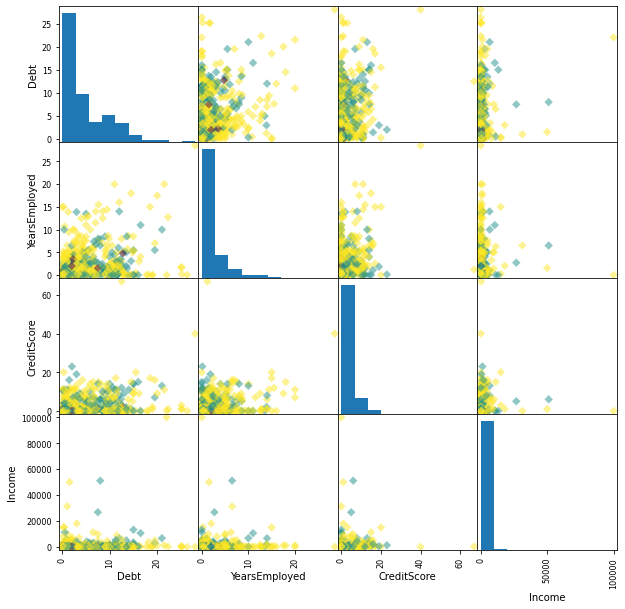

In [24]:
cores = y.astype('category').cat.codes
_ = pd.plotting.scatter_matrix(x, c=cores,figsize=[10,10], marker='D')

# Passo 4 - Treinamento do Modelo

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, stratify=y, random_state=RANDOM_STATE)

In [27]:
def build_classifiers():

    classifers = []

    classifers.append(
        ('knn',                              # nome do classificador
        KNeighborsClassifier(),             # instacia do classificador
        {'n_neighbors': range(1, 33, 2)})    # Hyperparamentro
    )

    classifers.append(
        ('LR',                             
        LogisticRegression(max_iter=1000), 
        {'penalty': ['l2'], 'C':[100,10,1,0.1,0.01]})    
    )

    classifers.append(
        ('svm',                              
        SVC(), 
        {'kernel': ['linear', 'rbf'], 'C':[2**(-5), 1, 2**5, 2**10],
        'gamma': [2**(-15), 2**(-10), 2**(-5), 1, 2**5]})   
    )

    classifers.append(
        ('dt',                              
        DecisionTreeClassifier(), 
        {'max_depth':[2, 4, 6, 8, 10, 12]})   
    )

    classifers.append(
        ('rf',                              
        RandomForestClassifier(), 
        {'n_estimators':[10, 50, 100,]})   
    )

    classifers.append(
        ('gpc',                              
        GaussianProcessClassifier(), 
        {'kernel':[1.0 * RBF(1.0)]})   
    )

    return classifers

# Passo 4.1 - Verificação métricas de treino 

In [28]:
classifiers = build_classifiers()
results = []
names = []
for name, model, parameters in classifiers:
    print('>> classifier name {}'.format(name))
    gs = GridSearchCV(estimator=model, param_grid=parameters, refit=True, verbose=0)
    kf = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
    cv = cross_val_score(gs, x_train, y_train, cv=kf, scoring='accuracy')
    print(f'Mean: {cv.mean()}, STD: {cv.std()}')
    results.append(cv)
    names.append(name)

>> classifier name knn
Mean: nan, STD: nan
>> classifier name LR
Mean: nan, STD: nan
>> classifier name svm
Mean: nan, STD: nan
>> classifier name dt
Mean: nan, STD: nan
>> classifier name rf
Mean: nan, STD: nan
>> classifier name gpc
Mean: nan, STD: nan
